In [2]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os

def collect_image_paths(root_dir):
    image_paths = []
    for set_folder in sorted(os.listdir(root_dir)):
        if set_folder.startswith('set'):
            set_path = os.path.join(root_dir, set_folder)
            for v_folder in sorted(os.listdir(set_path)):
                if v_folder.startswith('V'):
                    v_path = os.path.join(set_path, v_folder)
                    visible_folder = os.path.join(v_path, 'visible')
                    if os.path.exists(visible_folder):
                        for img_file in os.listdir(visible_folder):
                            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                                img_path = os.path.join(visible_folder, img_file)
                                image_paths.append(img_path)
    return image_paths

def collect_image_paths(root_dir):
    image_paths = []
    for img_file in os.listdir(root_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root_dir, img_file)
            image_paths.append(img_path)
            
    return image_paths

# Set the root directory of your dataset
root_dir = "/home/hice1/swise30/mae thermal only"

all_image_paths = collect_image_paths(root_dir)

print(f"Total images collected: {len(all_image_paths)}")

Total images collected: 200


In [4]:
import random

# Ensure reproducibility
random.seed(42)

# Check if we have at least 200 images
if len(all_image_paths) < 200:
    print("Not enough images in the dataset.")
else:
    selected_image_paths = random.sample(all_image_paths, 200)
    print(f"Selected {len(selected_image_paths)} images for fine-tuning.")

Selected 200 images for fine-tuning.


In [5]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
from torch.utils.data import DataLoader

dataset = CustomImageDataset(image_paths=selected_image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
from transformers import AutoImageProcessor, ViTMAEForPreTraining

processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

/home/hice1/swise30/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch.optim as optim
import torch

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAESdpaAttention(
            (attention): ViTMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=

Epoch 1/50, Loss: 0.008004072330480155
Epoch 2/50, Loss: 0.00027251624459705246
Epoch 3/50, Loss: 7.931168511277065e-05
Epoch 4/50, Loss: 3.181593931983046e-05
Epoch 5/50, Loss: 1.6692828327135292e-05
Epoch 6/50, Loss: 9.69843215268786e-06
Epoch 7/50, Loss: 7.362968972302042e-06
Epoch 8/50, Loss: 6.342246496597699e-06
Epoch 9/50, Loss: 5.5486575547547545e-06
Epoch 10/50, Loss: 4.997568339604186e-06
Epoch 11/50, Loss: 4.462153496066234e-06
Epoch 12/50, Loss: 4.03949633647034e-06
Epoch 13/50, Loss: 3.854345462829e-06
Epoch 14/50, Loss: 3.5726671880043937e-06
Epoch 15/50, Loss: 3.4642209636960897e-06
Epoch 16/50, Loss: 3.163691434775291e-06
Epoch 17/50, Loss: 2.9058793153616043e-06
Epoch 18/50, Loss: 2.7935631211361256e-06
Epoch 19/50, Loss: 2.668239438627587e-06
Epoch 20/50, Loss: 2.90012438269444e-06
Epoch 21/50, Loss: 2.6524968549123373e-06
Epoch 22/50, Loss: 2.4643132362073698e-06
Epoch 23/50, Loss: 2.3091010741784257e-06
Epoch 24/50, Loss: 2.153723156740083e-06
Epoch 25/50, Loss: 2.3

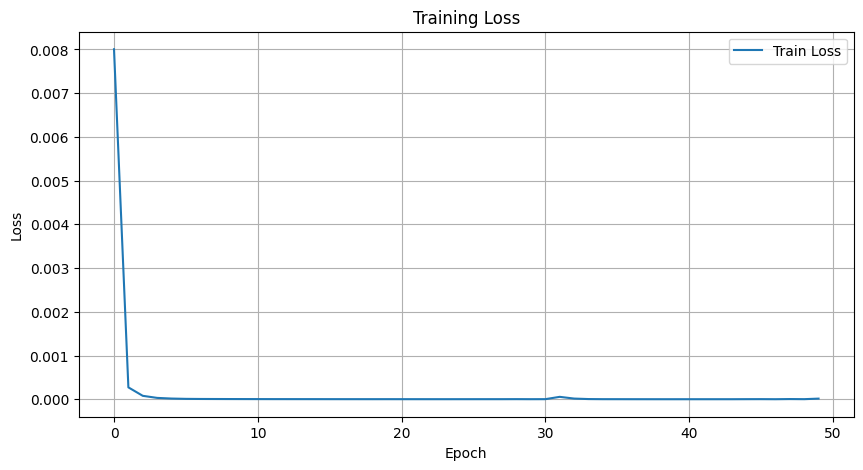

In [10]:
import json
import matplotlib.pyplot as plt

# Initialize storage for metrics
metrics = {"train_loss": []}
total_epoch_loss = []

epochs = 50  # You can adjust this number
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        images = batch.to(device)

        # Prepare inputs for the model
        inputs = processor(images=images, return_tensors="pt").to(device)

        # Forward pass
        outputs = model(**inputs)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    total_epoch_loss.append(epoch_loss)
    metrics["train_loss"].append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

# Save metrics to a JSON file
os.makedirs("/home/hice1/swise30/training_results_thermal", exist_ok=True)
with open("/home/hice1/swise30/training_results_thermal/metrics.json", "w") as f:
    json.dump(metrics, f)

# Save the trained model
model_save_path = "/home/hice1/swise30/training_results_thermal/trained_model"
model.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

# Plot and save Loss graph
plt.figure(figsize=(10, 5))
plt.plot(metrics["train_loss"], label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("/home/hice1/swise30/training_results_thermal/training_loss.png")
plt.show()

In [13]:
import numpy as np
loss_np = np.array(total_epoch_loss)
print(loss_np)

# Calculate average mask ratio
# Calculate average mask ratio
average_loss = np.mean(loss_np)
std_loss = np.std(loss_np)
print(f"\n")
print(f"Average Mask Ratio: {average_loss:.2%}")
print(f"Standard Deviation of Mask Ratio: {std_loss:.2%}")

[8.00407233e-03 2.72516245e-04 7.93116851e-05 3.18159393e-05
 1.66928283e-05 9.69843215e-06 7.36296897e-06 6.34224650e-06
 5.54865755e-06 4.99756834e-06 4.46215350e-06 4.03949634e-06
 3.85434546e-06 3.57266719e-06 3.46422096e-06 3.16369143e-06
 2.90587932e-06 2.79356312e-06 2.66823944e-06 2.90012438e-06
 2.65249685e-06 2.46431324e-06 2.30910107e-06 2.15372316e-06
 2.37059642e-06 2.40064500e-06 2.58432847e-06 2.66720850e-06
 3.41686970e-06 2.22422699e-06 3.01714441e-06 5.60304681e-05
 1.61829897e-05 5.09213388e-06 2.69968900e-06 2.42694805e-06
 2.03534171e-06 1.69464061e-06 1.52009763e-06 1.50233621e-06
 1.63819301e-06 1.67984495e-06 1.67189344e-06 1.73638349e-06
 2.83190443e-06 3.39762915e-06 1.78531334e-06 5.31797902e-06
 2.93912998e-06 1.51845593e-05]


Average Mask Ratio: 0.02%
Standard Deviation of Mask Ratio: 0.11%


# Check mask

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


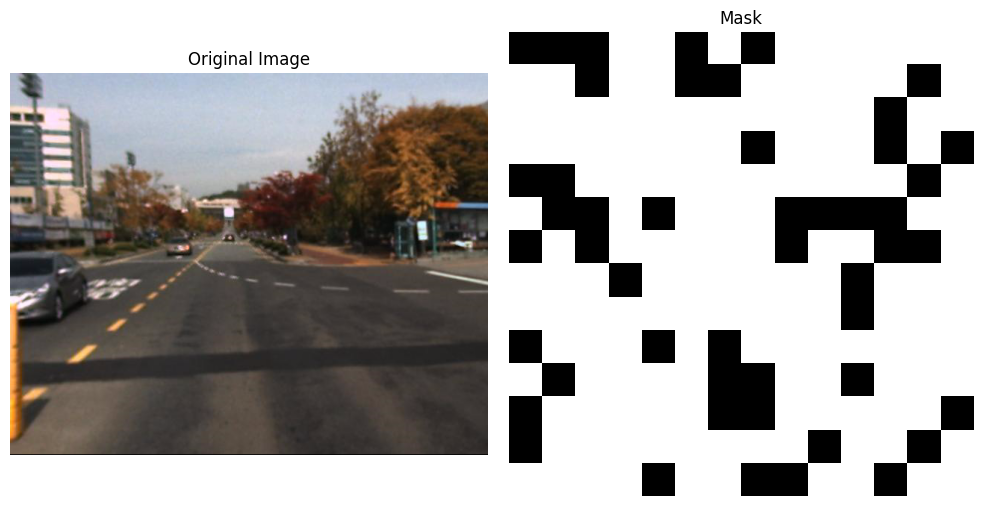

Mask Ratio: 75.00%
Number of masked patches: 147.0
Total number of patches: 196


In [14]:
import torch
from transformers import ViTMAEForPreTraining, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
model_path = "/home/hice1/swise30/training_results_thermal/trained_model"
model = ViTMAEForPreTraining.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")

# Prepare a sample image
image_path = "/home/hice1/swise30/dataset/test/kaist_test_visible/set06_V000_I00019_visible.png"  # Replace with an actual image path
image = Image.open(image_path).convert("RGB")

# Process the image and run it through the model
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Get the mask and reshape it
mask = outputs.mask.squeeze().cpu().numpy()
mask_reshaped = mask.reshape(14, 14)  # Assuming 14x14 patches for a 224x224 image
193.24
# Visualize the mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_reshaped, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print mask statistics
mask_ratio = mask.sum() / mask.size
print(f"Mask Ratio: {mask_ratio:.2%}")
print(f"Number of masked patches: {mask.sum()}")
print(f"Total number of patches: {mask.size}")